In [3]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

try:
    import cv2
    import keras
    import tensorflow as tf
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.models import Model
    from tensorflow.keras.utils import plot_model
    from tensorflow.keras.applications import VGG19
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

except ImportError:
    ! pip install keras
    ! pip install cv2
    import cv2
    import keras
    import tensorflow as tf
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.models import Model
    from tensorflow.keras.utils import plot_model
    from tensorflow.keras.applications import VGG19, ResNet101
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score 

In [4]:
train_path = '/kaggle/input/eeg-data30/eyes_open_closed_eeg_FALLCH_2/eyes_open_closed_eeg_FALLCH_2/train_data'
test_path = '/kaggle/input/eeg-data30/eyes_open_closed_eeg_FALLCH_2/eyes_open_closed_eeg_FALLCH_2/test_data'
# val_path = '/kaggle/input/eegdataforvgg/eyes_open_closed_eeg_F5CH_2/validation_data'

eyes_closed


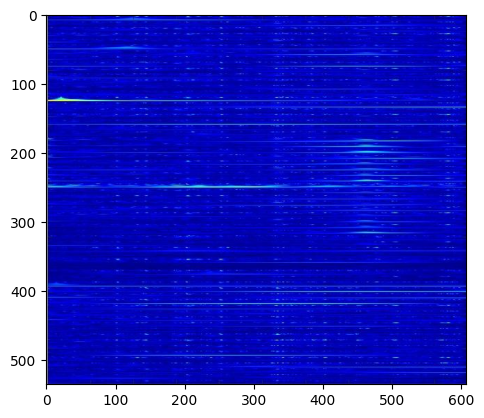

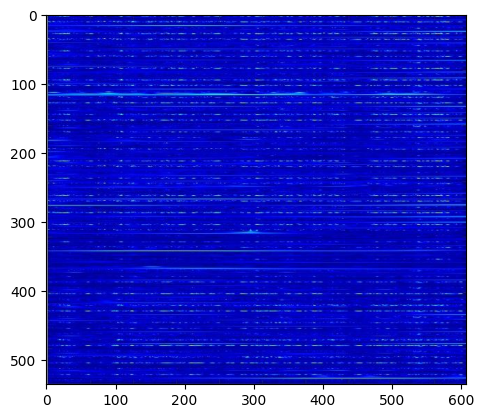

eyes_open


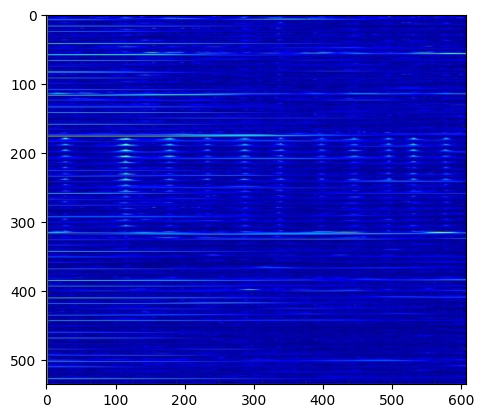

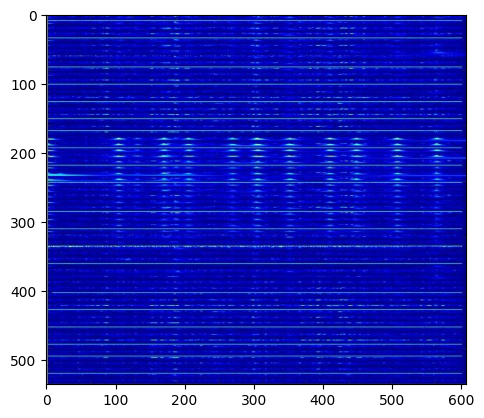

In [5]:
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder

    print(folder)
    for i in range(2):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path)
        implot = plt.imshow(img)
        plt.show()

In [6]:
def imagearray(path, size):
    data = []
    for folder in os.listdir(path):
        sub_path = os.path.join(path, folder)
        for img in os.listdir(sub_path):
            image_path = os.path.join(sub_path, img)
            img_arr = cv2.imread(image_path)
            img_arr = cv2.resize(img_arr, size)
            data.append(img_arr)
    return data

In [7]:
# Function to create data generators for the classes
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale=1./255)
    classes = datagen.flow_from_directory(data_path,
                                          target_size=size,
                                          batch_size=32,
                                          class_mode=class_mode)
    return classes


In [8]:
size = (224, 224)

# Load and resize the images
train = imagearray(train_path, size)
test = imagearray(test_path, size)
# val = imagearray(val_path, size)

# Convert lists of images to numpy arrays and normalize the pixel values
x_train = np.array(train) / 255
x_test = np.array(test) / 255
# x_val = np.array(val) / 255

# Create data generators for the classes
train_class = data_class(train_path, size, 'sparse')
test_class = data_class(test_path, size, 'sparse')
# val_class = data_class(val_path, size, 'sparse')

# Get the class labels from the generators
y_train = train_class.classes
y_test = test_class.classes
# y_val = val_class.classes

Found 152 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


In [9]:
# Load the VGG19 model, pre-trained on ImageNet
model_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base_model
for layer in model_VGG19.layers:
    layer.trainable = False

# Create the model
model = keras.Sequential([
    model_VGG19,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])
# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)
# Evaluate the model
model.evaluate(x_test, y_test)

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10
5/5 [==============================] - 20s 972ms/step - loss: 3.9757 - accuracy: 0.5461
Epoch 2/10
5/5 [==============================] - 1s 136ms/step - loss: 1.2542 - accuracy: 0.5329
Epoch 3/10
5/5 [==============================] - 1s 138ms/step - loss: 1.1772 - accuracy: 0.5724
Epoch 4/10
5/5 [==============================] - 1s 136ms/step - loss: 0.7361 - accuracy: 0.6250
Epoch 5/10
5/5 [==============================] - 1s 137ms/step - loss: 0.6675 - accuracy: 0.6513
Epoch 6/10
5/5 [==============================] - 1s 136ms/step - loss: 0.5620 - accuracy: 0.7237
Epoch 7/10
5/5 [==============================] - 1s 136ms/step - loss: 0.5244 - accuracy: 0.7303
Epoch 8/10
5/5 [==============================] - 1s 137ms/step - loss: 0.4638 - accuracy: 0.8092
Epoch 9/10
5/5 [==============================] - 1s 138ms/step - loss: 0.4517 - accuracy: 0.8224
Epoch 10/10
3/3 [==============================] - 1

[0.41300493478775024, 0.8333333134651184]

3/3 [==============================] - 0s 132ms/step


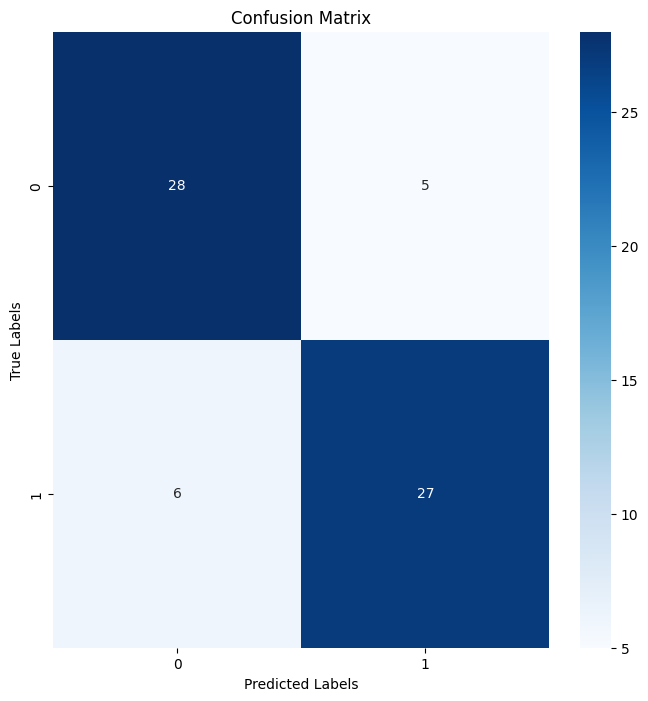

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set (assuming your test images are preprocessed)
predictions = model.predict(x_test)
# Convert predictions from probabilities to binary (0 or 1) using 0.5 as a threshold
predicted_classes = np.where(predictions > 0.5, 1, 0)

# Assuming y_test contains the true labels in the same order as x_test
true_classes = y_test

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using Seaborn
# (You can skip this step if you don't need a visual representation)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()


In [11]:
# Define the image size for resizing
size = (250, 250)

# Load and resize the images
train = imagearray(train_path, size)
test = imagearray(test_path, size)
# val = imagearray(val_path, size)

# Convert lists of images to numpy arrays and normalize the pixel values
x_train = np.array(train) / 255
x_test = np.array(test) / 255
# x_val = np.array(val) / 255

# Create data generators for the classes
train_class = data_class(train_path, size, 'sparse')
test_class = data_class(test_path, size, 'sparse')
# val_class = data_class(val_path, size, 'sparse')

# Get the class labels from the generators
y_train = train_class.classes
y_test = test_class.classes
# y_val = val_class.classes

Found 152 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


In [12]:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

In [13]:
# Create the CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # Adjust the number of outputs to match the number of classes
])
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
model.fit(x_train, y_train, epochs=10)
# Evaluate the model
model.evaluate(x_test, y_test)

Epoch 1/10
5/5 [==============================] - 6s 185ms/step - loss: 6.7437 - accuracy: 0.4868
Epoch 2/10
5/5 [==============================] - 0s 44ms/step - loss: 1.1826 - accuracy: 0.5921
Epoch 3/10
5/5 [==============================] - 0s 45ms/step - loss: 0.5513 - accuracy: 0.8026
Epoch 4/10
5/5 [==============================] - 0s 45ms/step - loss: 0.4842 - accuracy: 0.7368
Epoch 5/10
5/5 [==============================] - 0s 46ms/step - loss: 0.3771 - accuracy: 0.8553
Epoch 6/10
5/5 [==============================] - 0s 45ms/step - loss: 0.2630 - accuracy: 0.9013
Epoch 7/10
5/5 [==============================] - 0s 45ms/step - loss: 0.1922 - accuracy: 0.9145
Epoch 8/10
5/5 [==============================] - 0s 46ms/step - loss: 0.1243 - accuracy: 0.9671
Epoch 9/10
5/5 [==============================] - 0s 45ms/step - loss: 0.0869 - accuracy: 0.9803
Epoch 10/10
3/3 [==============================] - 0s 45ms/step - loss: 0.6093 - accuracy: 0.8030


[0.6093397736549377, 0.8030303120613098]

3/3 [==============================] - 0s 19ms/step


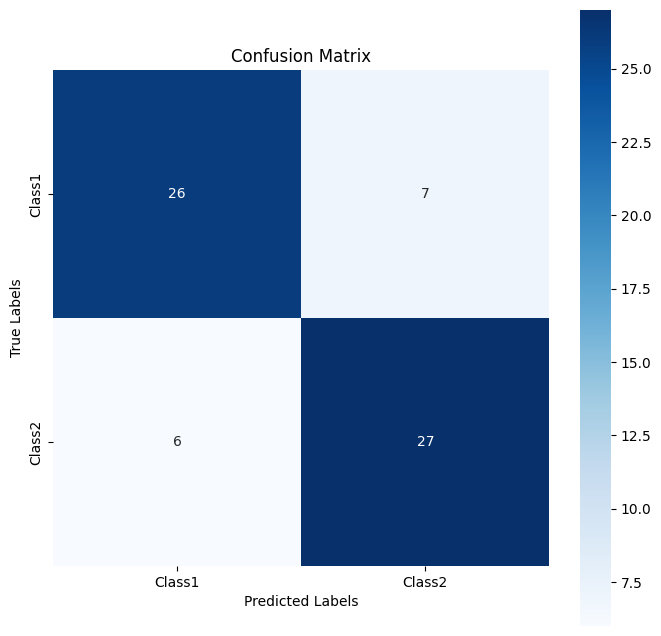

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(x_test)
# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix using Seaborn
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', square=True)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Labels might be ['Class1', 'Class2', ..., 'ClassN']
class_names = ['Class1', 'Class2']  # Replace with your actual class names
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Show the plot
plt.show()